# G10 Notebook             AA1

## 1. Notebook description:

#### The aim of this notebook is to train an Agent to balance a cube and a ball over his head one on top of the other. We will  document all the changes and decisions that we will have to make over the process of the training and show how those parameter changes make the training evolve in diferent directions.

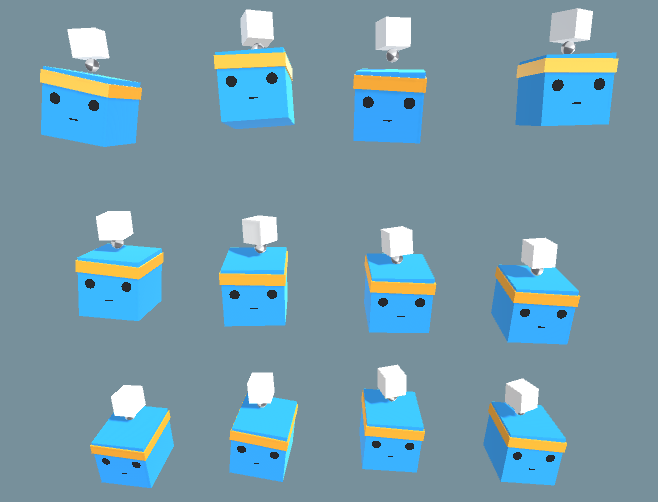

## 2. Case analysis:

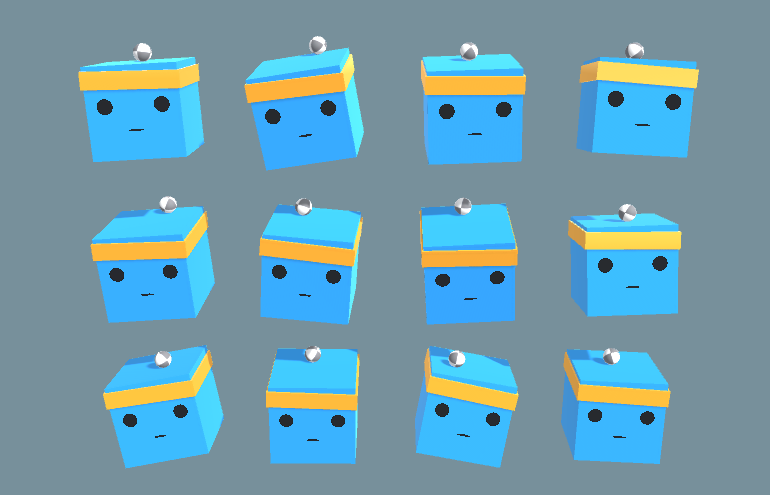

#### In the example we have an agent that balances a ball in his head. To do so, he only can rotate his head in the X, Z plane.

    public override void CollectObservations()
    {
        AddVectorObs(gameObject.transform.rotation.z);
        AddVectorObs(gameObject.transform.rotation.x);

        AddVectorObs(ball1.transform.position - gameObject.transform.position);
        
        AddVectorObs(m_BallRb1.velocity);
    }

#### The Agent takes as observations his X and Z rotations and the vector that goes from the center of the head to the center of the ball.

#### The resulting action vector only holds 2 parameters that correspond to the amount of rotation in X and Z. 

#### The values are always clamped to be normalized and then multipled by 2 because that is the maximum amount that an agent can rotate in one frame.

#### Furthermore, the agent will only be able to rotate to a maxium of 0.25 on each angle.

    public override void AgentAction(float[] vectorAction)
    {
        var actionZ = 2f * Mathf.Clamp(vectorAction[0], -1f, 1f);
        var actionX = 2f * Mathf.Clamp(vectorAction[1], -1f, 1f);

        if ((gameObject.transform.rotation.z < 0.25f && actionZ > 0f) ||
            (gameObject.transform.rotation.z > -0.25f && actionZ < 0f))
        {
            gameObject.transform.Rotate(new Vector3(0, 0, 1), actionZ);
        }

        if ((gameObject.transform.rotation.x < 0.25f && actionX > 0f) ||
            (gameObject.transform.rotation.x > -0.25f && actionX < 0f))
        {
            gameObject.transform.Rotate(new Vector3(1, 0, 0), actionX);
        }



#### Once the agent has performed the rotating action, it's time to reward his actions.

#### In this training we are giving every step a positive reward of 0.1 if the agent keeps the ball balanced in his head, but if the ball falls from one of the sides or gets too far from the center of the head, we then give a negative reward of -1 and end the episode.

        if ((ball1.transform.position.y - gameObject.transform.position.y) < -2f ||
            Mathf.Abs(ball1.transform.position.x - gameObject.transform.position.x) > 3f ||
            Mathf.Abs(ball1.transform.position.z - gameObject.transform.position.z) > 3f)
        {
            SetReward(-1f);
            Done();
        }
        else
        {
            SetReward(0.1f);
        }
    }

#### Once an episode is finished we reset the ball and the head to a initial state.

    public override void AgentReset()
    {
        gameObject.transform.rotation = new Quaternion(0f, 0f, 0f, 0f);
        gameObject.transform.Rotate(new Vector3(1, 0, 0), Random.Range(-10f, 10f));
        gameObject.transform.Rotate(new Vector3(0, 0, 1), Random.Range(-10f, 10f));
        m_BallRb1.velocity = new Vector3(0f, 0f, 0f);
        ball1.transform.position = new Vector3(Random.Range(-0.6f, -1.5f), 4f, Random.Range(-1.5f, 1.5f)) +
        gameObject.transform.position;
        
        //Reset the parameters when the Agent is reset.
        SetResetParameters();
    }

## 3. Performance analysis:

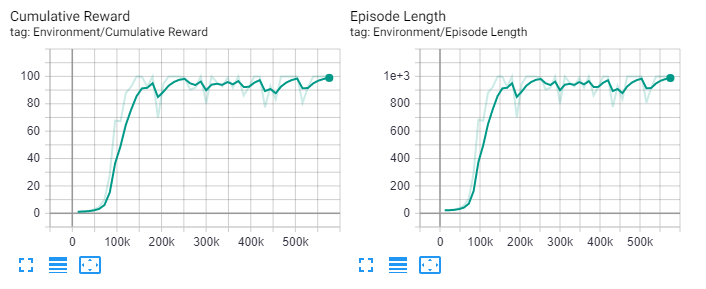
#### This results are from the case described above. As you can see, the learning curve is quite steep until it reaches the maximum potential which is around the 100 reward.

#### This is due to having set a positive reward every frame. It's always a great practice to train your agents with positive rewards intead of punishing them with bad rewards.

#### Another key element to et a good learning curve is to give as much information to the agent as posible about the state of the environment. Below is a case where the agent wasn't given all the observations needed for a good training.

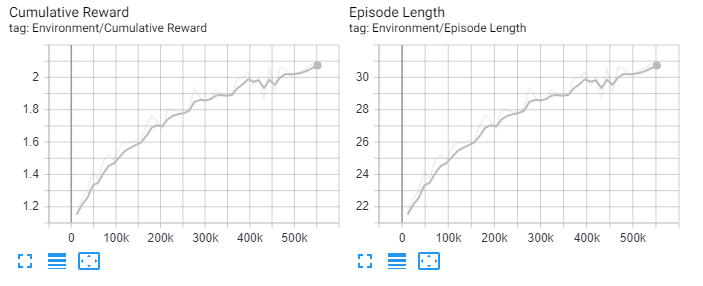

#### As you can see, the maximum potential in the same amount of steps was around 2, that is because of the lack of information the agent has about its sorroundings. And even the learning curve in that amount of steps was going upwards, it was starting to reach a flat spot which could mean that the agent can't complete the task with the given information.

## 4. New case proposal:

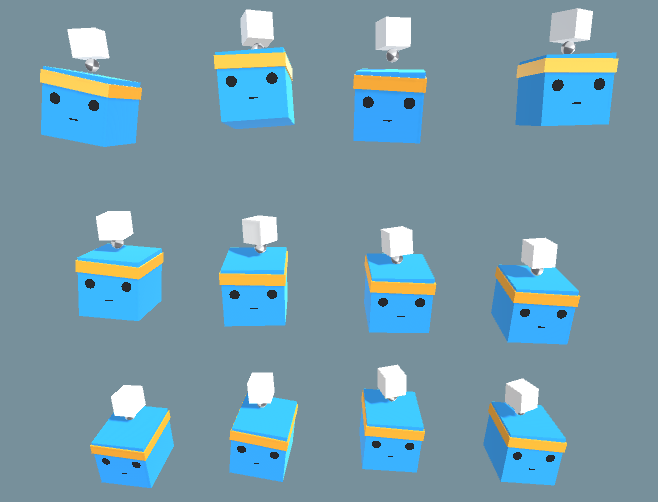

#### As said at the beginning, our proposal is to take the agent that balances a ball on his head and make the task more difficult by making the agent try to balance the ball and a cube on top of the ball

#### First of all we tried to train the agent with the initial restriction of only being capable of rotating in the XZ plane and that's what happened:
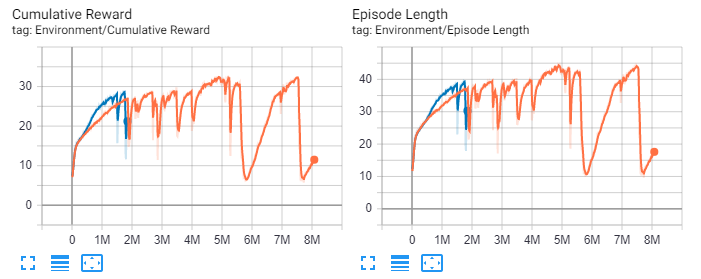
#### As you can see, the agent was reaching a maximum potential over and over again that was caused by not having enough tools to perform the task. Actually, the episode length was the maximum time the cube hold without touching the head.

#### As this didn't work, we tried giving the agent lateral movement apart from the XZ rotation and that is what happened:
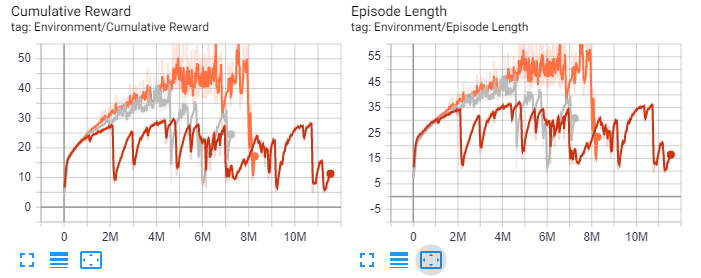
#### The agent performed better than in the past tests but was finding really low maximum potenitals, again, due to a lack of tools to perfom the task. It's understandable when you think about circus equilibrists or when you try to balance a broom on your hand, you need to move your hand in all directions in order to balance it.

#### So lastly we tried giving the agent full 3D movement and rotation in the XZ axis and that is what happened:
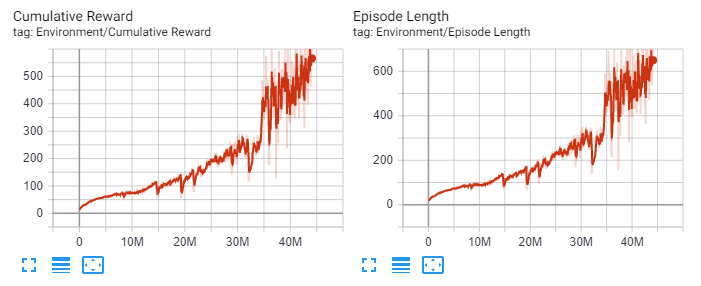
#### The agent performed surprisingly well after a long training session and was able to balance both objects for quite long time.

#### Now we are going to show which observations and rewards setted in the agent in order to perform this training:

#### For the observations, we added the whole position of the head in the world, a vector Head-->Cube and a vector Ball-->Cube. Also we added the velocity of the cube and the Up vector from the cube. 

    public override void CollectObservations()
    {
        AddVectorObs(gameObject.transform.rotation.z);
        AddVectorObs(gameObject.transform.rotation.x);

        AddVectorObs(gameObject.transform.position.z);
        AddVectorObs(gameObject.transform.position.x);
        AddVectorObs(gameObject.transform.position.y);

        AddVectorObs(ball.transform.position - gameObject.transform.position);
        AddVectorObs(cube.transform.position - gameObject.transform.position);
        AddVectorObs(cube.transform.position - ball.transform.position);

        AddVectorObs(m_BallRb.velocity);
        AddVectorObs(m_CubeRb.velocity);
        AddVectorObs(cube.transform.up);

    }

#### For the actions we added the full movement to the agent and clamped to a maximum distance of 2 in each axis from the 0,0,0

    public override void AgentAction(float[] vectorAction)
    {
        var actionRotateZ = 2f * Mathf.Clamp(vectorAction[0], -1f, 1f);
        var actionRotateX = 2f * Mathf.Clamp(vectorAction[1], -1f, 1f);
        var actionMoveZ = 0.5f * Mathf.Clamp(vectorAction[2], -1f, 1f);
        var actionMoveX = 0.5f * Mathf.Clamp(vectorAction[3], -1f, 1f);
        var actionMoveY = 0.5f * Mathf.Clamp(vectorAction[4], -1f, 1f);

        //Rotation
        if ((gameObject.transform.rotation.z < 0.25f && actionRotateZ > 0f) ||
            (gameObject.transform.rotation.z > -0.25f && actionRotateZ < 0f))
        {
            gameObject.transform.Rotate(new Vector3(0, 0, 1), actionRotateZ);
        }

        if ((gameObject.transform.rotation.x < 0.25f && actionRotateX > 0f) ||
            (gameObject.transform.rotation.x > -0.25f && actionRotateX < 0f))
        {
            gameObject.transform.Rotate(new Vector3(1, 0, 0), actionRotateX);
        }

        //Movement
        if ((gameObject.transform.localPosition.z < maxMoveDist && actionMoveZ > 0f) ||
            (gameObject.transform.localPosition.z > -maxMoveDist && actionMoveZ < 0f))
        {
            gameObject.transform.localPosition = new Vector3(gameObject.transform.localPosition.x, gameObject.transform.localPosition.y, gameObject.transform.localPosition.z + actionMoveZ);
        }

        if ((gameObject.transform.localPosition.x < maxMoveDist && actionMoveX > 0f) ||
            (gameObject.transform.localPosition.x > -maxMoveDist && actionMoveX < 0f))
        {
            gameObject.transform.localPosition = new Vector3(gameObject.transform.localPosition.x + actionMoveX, gameObject.transform.localPosition.y, gameObject.transform.localPosition.z);
        }

        if ((gameObject.transform.localPosition.y < maxMoveDist && actionMoveY > 0f) ||
            (gameObject.transform.localPosition.y > -maxMoveDist && actionMoveY < 0f))
        {
            gameObject.transform.localPosition = new Vector3(gameObject.transform.localPosition.x, gameObject.transform.localPosition.y + actionMoveY, gameObject.transform.localPosition.z);
        }

#### For the rewards we added to the negative rewards the case where the cube has fallen from the head, the case where the cube is too far away from the head, the case where the cube has fallen from the ball and finally the case where the cube has rotated more than the desired. In this case the maximum desired rotation was 45º in any angle.

#### For the positive rewards, we devided the maximum reward in 3 sections:
#### - Ball Reward
#### - Cube Reward
#### - Head Reward
#### All 3 rewards have a maximum reward of 0.95 and a minimum reward of 0.1, this amount oscilates by how well is the agent doing the task.

#### For the ball reward, we give more reward if the ball is closer to the center of the head.

#### For the cube reward, we give more reward if the cube is closer to the perfect balance which is with his up vector pointing upwards.

#### For the head reward, we give more reward if the head is close to the center 0 in the Y axis.

    //Rewards
        if ((ball.transform.position.y - gameObject.transform.position.y) < -2f ||
            (cube.transform.position.y - gameObject.transform.position.y) < -2f ||
            Mathf.Abs(ball.transform.position.x - gameObject.transform.position.x) > 3f ||
            Mathf.Abs(ball.transform.position.z - gameObject.transform.position.z) > 3f ||
            cube.transform.position.y - ball.transform.position.y < 1f ||
            Vector3.Dot(cube.transform.up, Vector3.up) < normalThreshold)
        {
            SetReward(-1f);
            Done();
        }
        else
        {
            float xDist = Mathf.Abs((ball.transform.position - transform.position).x);
            float zDist = Mathf.Abs((ball.transform.position - transform.position).z);

            float ballXReward = Mathf.Lerp(maxReward, minReward, (xDist/ 3f));
            float ballZReward = Mathf.Lerp(maxReward, minReward, (zDist / 3f));
            float ballReward = (ballXReward + ballZReward) / 2f;

            float cubeReward = Mathf.Lerp(minReward, maxReward, (Vector3.Dot(cube.transform.up, Vector3.up) - normalThreshold) * 1f/(1f-normalThreshold));

            float headReward = Mathf.Lerp(maxReward, minReward, Mathf.Abs(gameObject.transform.localPosition.y) / maxMoveDist);

            float reward = (ballReward + cubeReward + headReward) / 3f;
            SetReward(reward);
        }
    }

## 5. Team

#### This team is conformed by:
#### Ivan Anfruns
##### miguelanfrunsortiz@enti.cat
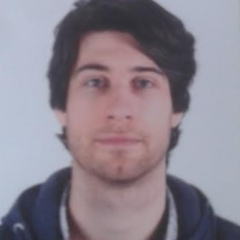

#### Guillermo Esteban
##### guillermoestebanplazas@enti.cat
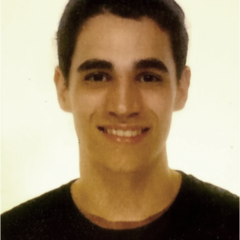